In [1]:
#Import and declare TIC

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from scipy.interpolate import make_interp_spline as spline
import scipy.signal as signal
import matplotlib

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 337646214'

#Download the data and stitch it together
search_results = lk.search_lightcurve(TIC, cadence='short', author='SPOC')
print(search_results)


SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 44 2021   SPOC     120   337646214      0.0
  1 TESS Sector 45 2021   SPOC     120   337646214      0.0
  2 TESS Sector 46 2021   SPOC     120   337646214      0.0
  3 TESS Sector 72 2023   SPOC     120   337646214      0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

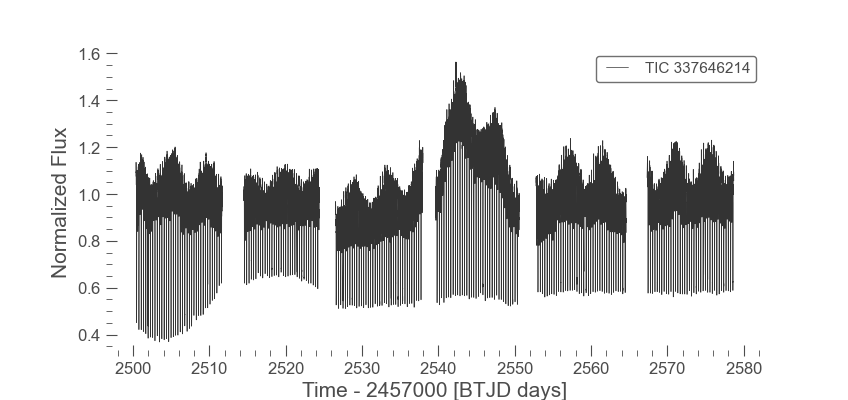

In [2]:
#Downloading, stitching and plotting the data

use_till = 3            #Number of data points to use                                               [INPUT NEEDED]
used_result = search_results[0:use_till]
lc = used_result.download_all().stitch()

lc.plot()

In [3]:
#Fills in all the gaps with straight lines

#Setting up the arrays
time = np.array(lc.time.btjd)
cadence_multiplier = 86400/(np.median(np.diff(time[0:100])) * 86400).round()
time = (time - time[0]) * cadence_multiplier
time = time.round(0)
flux = np.array(lc.flux, dtype=float)
lightcurvepd = pd.DataFrame({'Time':time, 'Flux':flux})

#Filling in missing times with nans
time_interval = 1
min_time = time[0]
max_time = time[-1]
full_time = np.arange(min_time, max_time + time_interval, time_interval)
lightcurvepd.set_index('Time', inplace=True)
lightcurvepd = lightcurvepd.reindex(full_time)

#Filling in the Nans by interpolation
lightcurvepd['Flux'].interpolate(method='linear', inplace=True)

#reset index
lightcurvepd.reset_index(inplace=True)
lightcurvepd.rename(columns={'index':'Time'}, inplace=True)
lightcurvepd['Time'] = (lightcurvepd['Time'] / cadence_multiplier) + lc.time.btjd[0] + 2457000
lightcurvepd.dropna(inplace=True)
lightcurvepd.reset_index(inplace=True)

#Making the light curve smoother, with a spline interpolation
time_smooth = np.linspace(lightcurvepd['Time'].min(), lightcurvepd['Time'].max(), len(lightcurvepd['Time']) * 8)
spl = spline(lightcurvepd['Time'], lightcurvepd['Flux'], k=3)
flux_smooth = spl(time_smooth)
del lightcurvepd
lightcurvepd = pd.DataFrame({'time':time_smooth, 'flux':flux_smooth})

#Printing the number of timestamps (the length of the timeseries array)
timeseries_length = len(lightcurvepd['time'])
print(f'The number of timestamps in the timeseries is: {timeseries_length}')
print("Provide a fraction of this value to the next function")

The number of timestamps in the timeseries is: 451152
Provide a fraction of this value to the next function


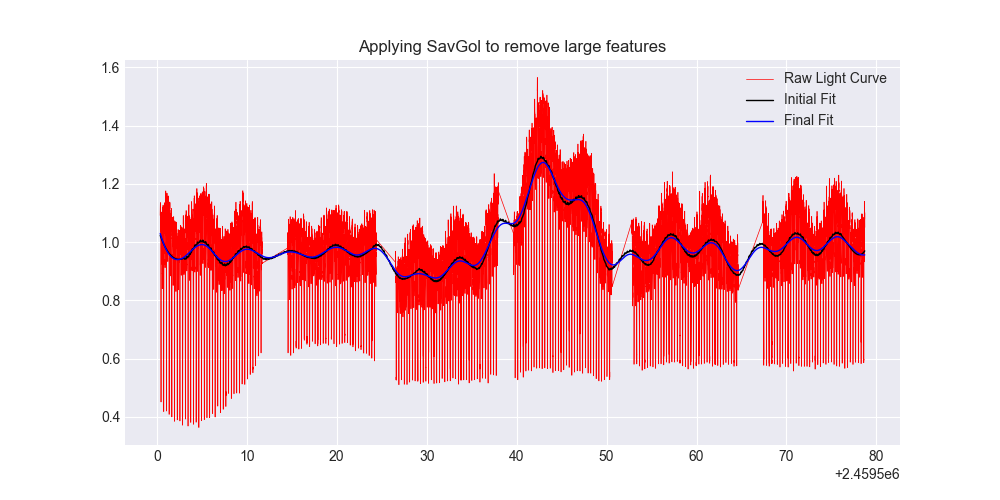

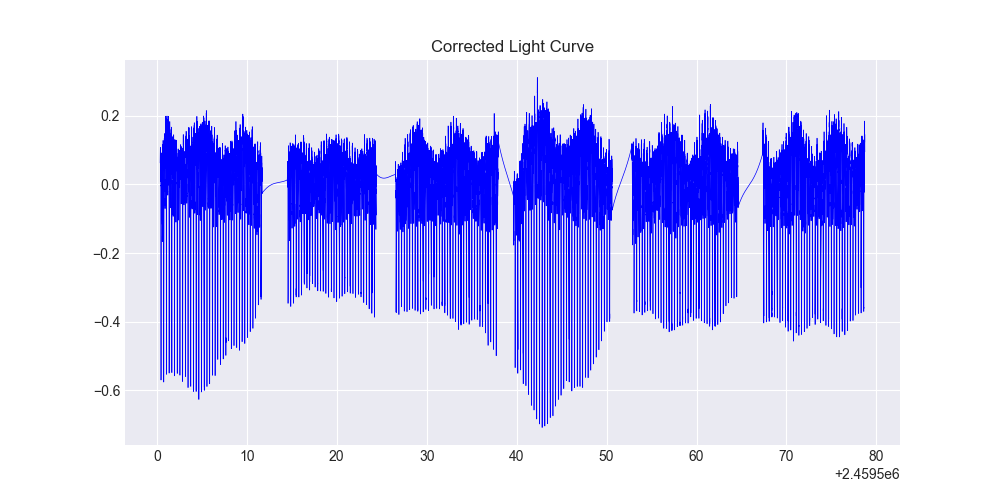

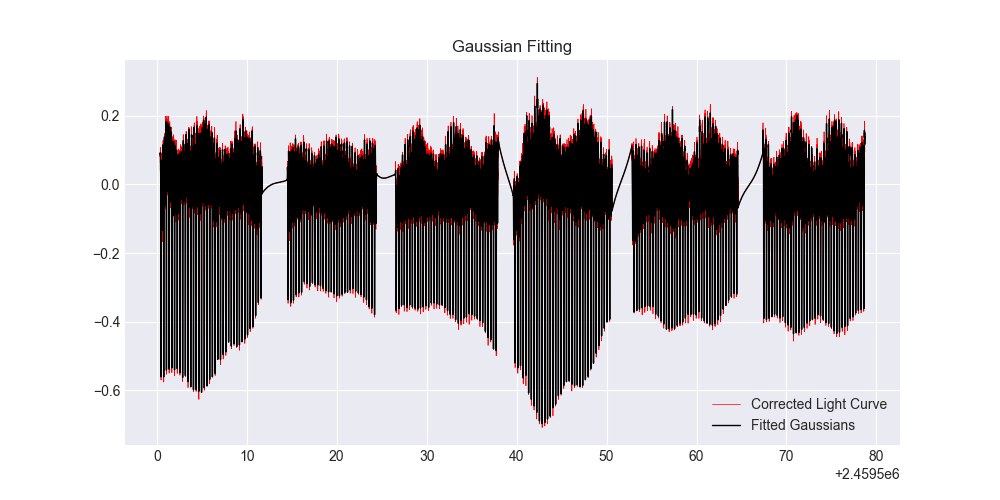

In [10]:
#Applying the savgol filter and plotting (This part defines the function AND removes the big features)

def apply_savgol_filter(time, flux, mode : str = 'remove', window_length_for_gaussian : int = 100, window_length_for_remove : int = int(timeseries_length/20), polyorder = 4) -> pd.DataFrame:
    '''
    Applies the savgol filter to `flux` and `time`.

    Works in two modes:
    - `'remove'`: Removes the outburst and other large features
    - `'gaussian'`: Finds the gaussians, techincally

    Parameters:
    ----------
    time : array-like
        The time array of the lightcurve
    flux : array-like
        The flux array of the lightcurve
    mode : str
        The mode in which the function should work, either `'remove'` or `'gaussian'`
    window_length_for_gaussian : int
        The window length for the gaussian filter, works only in `'gaussian'` mode
    window_length_for_remove : int
        The window length for the remove filter, works only in `'remove'` mode
    polyorder : int
        The polynomial order for the savgol filter

    Returns:
    ----------
    if `mode == 'remove'`:
        returns the corrected lightcurve as a pandas.DataFrame object
        Columns: `'time'` and  `'flux'`
    if `mode == 'gaussian'`:
        returns the gaussians as a pandas.DataFrame object
        Columns: `'time'` and  `'gaussian_flux'`

    '''
    if mode == 'remove':  #Removing the outburst and other large features
        flx = signal.savgol_filter(flux, int(window_length_for_remove), polyorder)
        flx2 = signal.savgol_filter(flx, int(window_length_for_remove), polyorder)
        #plotting the savgol
        plt.figure(figsize=(10, 5))
        plt.title('Applying SavGol to remove large features')
        plt.plot(time, flux, 'r-', lw=0.5, label='Raw Light Curve')
        plt.plot(time, flx, 'k-', lw=1, label='Initial Fit')
        plt.plot(time, flx2, 'b-', lw=1, label='Final Fit')
        plt.legend()

        #plotting the processed graph
        plt.figure(figsize=(10, 5))
        plt.title('Corrected Light Curve')
        plt.plot(time, flux - flx2, 'b-', lw=0.5)

        #Building the lightcurve again, with the correction
        return pd.DataFrame({
            'time':time,
            'flux':flux - flx2
        }, index=None)

    elif mode == 'gaussian':   #Finding the gaussians, techincally
        fit_flux = signal.savgol_filter(flux, int(window_length_for_gaussian), polyorder)
        plt.figure(figsize=(10, 5))
        plt.title('Gaussian Fitting')
        plt.plot(time, flux, 'r-', lw=0.5, label='Corrected Light Curve')
        plt.plot(time, fit_flux, 'k-', lw=1, label='Fitted Gaussians')
        plt.legend()

        return pd.DataFrame({
            'time':time,
            'gaussian_flux': - fit_flux
        }, index=None)

window_length_for_remove = 30000        #The window length for the remove filter                        [INPUT NEEDED]
window_length_for_gaussian = 200        #The window length for the gaussian filter                      [INPUT NEEDED]

#Getting the corrected LC as a DataFrame
corrected = apply_savgol_filter(lightcurvepd['time'], lightcurvepd['flux'], mode = 'remove', window_length_for_remove= window_length_for_remove, polyorder = 3)

#Finding Gaussians
gaussian_df = apply_savgol_filter(corrected['time'], corrected['flux'], mode = 'gaussian', window_length_for_gaussian = window_length_for_gaussian)


Outliers Removed:  20


Text(0, 0.5, 'Period')

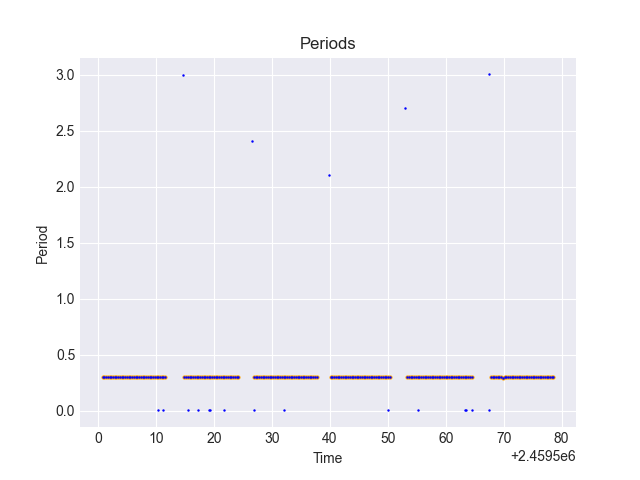

In [5]:
#Function for checking the differences in peaks
def process_gaussians(fitted : lk.lightcurve.LightCurve | pd.DataFrame, threshold, number_of_gaps = 10):
    '''
    Finds the peaks, the periods and mean of the periods for fitted gaussians curve.

    Parameters:
    -----------
    `fitted` : `lightkurve.LightCurve` or `pd.Dataframe` with columns `'time'` and `'gaussian_flux'` 
        The lightcurve that has been fitted for gaussians.
    `threshold` : `float`
        The threshold for the peak detection.
    `number_of_gaps` : `int`
        (default = 10)
        The aproximate number of gaps, always enter a much higher value than the true number.

    Returns:
    --------
    mean_diff : `float`
        The mean difference between the peaks.
    peaks_n_periods : `pd.DataFrame`
        Columns:
        - 'period' : The periods between the peaks
        - 'time' : The peak times. If is period is `p2 - p1`, this returns `p2`.
    '''

    import lightkurve as lk
    import pandas as pd
    from scipy.signal import find_peaks
    import numpy as np
    import matplotlib.pyplot as plt

    # Get the flux and time values
    if isinstance(fitted, lk.LightCurve):
        fl = np.array(fitted.flux)
        tm = np.array(fitted.time.btjd)
    if isinstance(fitted, pd.DataFrame):
        fl = np.array(fitted['gaussian_flux'])
        tm = np.array(fitted['time'])

    # Find peaks in fl above threshold
    peaks, _ = find_peaks(fl, height=threshold)

    # Get the associated time values for the peaks
    peak_times = tm[peaks]

    mean_diff = np.sort(np.diff(peak_times))[: - number_of_gaps].mean()

    return mean_diff, pd.DataFrame({
        'period' : np.diff(peak_times),
        'time' : peak_times[1:]
    })

#Functions for rejecting outliers
def reject_outliers(data, m=1):
    removed = data[abs(data - np.mean(data)) > m * np.std(data)]
    print("Outliers Removed: ", len(removed))
    accepted = data[abs(data - np.mean(data)) < m * np.std(data)]
    plt.figure()
    plt.plot(accepted)
    return accepted
def reject_outliers_pd(data : pd.DataFrame, column_name : str, m=1):
    '''
    Removes the outliers from the data.

    Parameters:
    ----------
    data : pd.DataFrame
        The data from which the outliers are to be removed.
    column_name : str
        The column name from which the outliers are to be removed.
    m : int
        The number of standard deviations to be considered as an outlier.
    
    Returns:
    --------
    accepted : pd.DataFrame
        The data with the outliers removed.
    Prints the number of outliers removed.
    
    '''
    removed = data[abs(data[column_name] - np.mean(data[column_name])) > m * np.std(data[column_name])]
    print("Outliers Removed: ", len(removed))
    accepted = data[abs(data[column_name] - np.mean(data[column_name])) < m * np.std(data[column_name])]
    accepted.reset_index(inplace=True, drop=True)
    return accepted

#Function for making the O-C diagram
def make_OC_diagram(accepted : pd.DataFrame):
    '''
    Makes the O-C diagram from the accepted data.

    Parameters:
    ----------
    accepted : pd.DataFrame
        The data from which the O-C diagram is to be made. Must have columns 'time' and 'period'.
    
    Returns:
    --------
    OC_DataFrame : pd.DataFrame
        The O-C diagram data.
        Columns:
        - 'T' : Time of the period from the start
        - 'E' : Event Number
        - 'O-C' : The O-C values
    '''
    df = accepted.copy(deep=True)

    df['T'] = df['time'] - df['time'][0]
    p0 = df['period'][0]
    df['p_'] = [ ( df['period'][:x].sum() / x ) for x in range(1, len(df) + 1)]
    df['E'] = df['T'] / df['p_']
    df['E'] = df['E'].astype(int)
    df['O-C'] = df['T'] * ( 1 - ( p0 / df['p_'] ) )
    return df[['T', 'E', 'O-C']]

m = 0.25                #Number of standard deviations to be considered as an outlier               #INPUT NEEDED
threshold = 0.2         #Threshold for the peak detection                                           #INPUT NEEDED
number_of_gaps = 10     #Number of gaps to be considered                                            #INPUT NEEDED

#Finding the peaks and periods
mean_diff, times_n_periods = process_gaussians(gaussian_df, threshold, number_of_gaps)
accepted_times_n_periods = reject_outliers_pd(times_n_periods, 'period', m)                 

#Plotting the periods
plt.figure()
plt.title('Periods')
plt.plot(accepted_times_n_periods['time'], accepted_times_n_periods['period'], color = 'orange', marker = '.', markersize = 4, lw = 0, label = 'Accepted Periods')
plt.plot(times_n_periods['time'], times_n_periods['period'], color = 'blue', marker = '.', markersize = 1.5, lw = 0, label = 'All Periods')
plt.xlabel('Time')
plt.ylabel('Period')

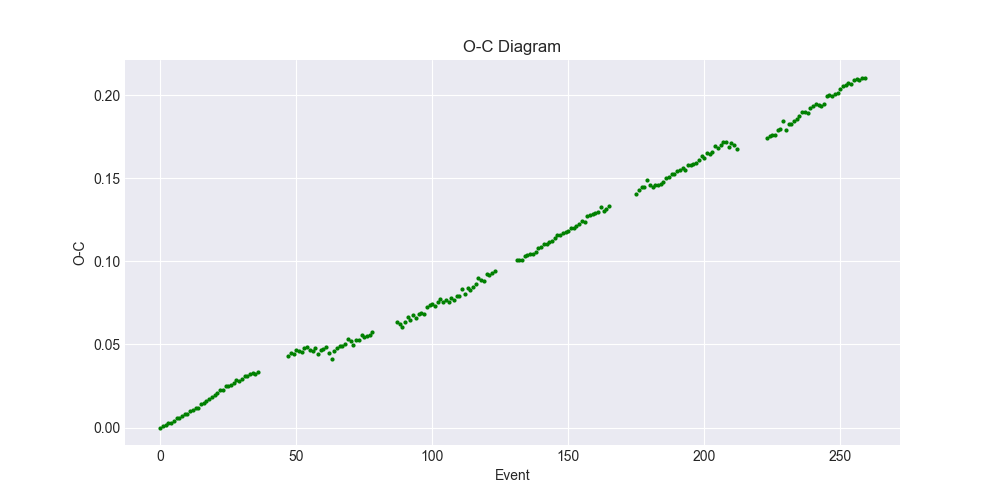

In [12]:
#Function for making OC diagram
OC_DataFrame = make_OC_diagram(accepted_times_n_periods)

#Plotting the O-C diagram
plt.figure(figsize=(10, 5))
plt.title('O-C Diagram')
plt.plot(OC_DataFrame['E'], OC_DataFrame['O-C'], color = 'green', marker = '.', markersize = 4, lw = 0, label = 'O-C Diagram')
plt.xlabel('Event')
plt.ylabel('O-C')
plt.show()